### [ML - 생성 분류 모델 만들기 5]
- 주제 : 2개 종류 생선 분류 모델 만들기
- 학습 종류 : 지도학습 -> 분류
- 학습 방법 : 다양한 분류 알고리즘들 => KNN 최근접이웃 알고리즘

- 데이터셋
    * 학습용 데이터셋
        - 모델 학습에 즉, 데이터의 규칙과 패턴을 찾기 위해 사용되는 데이터셋
    
    * 검증용 데이터셋
        - 모델 학습 중 제대로 규칙과 패턴을 찾고 있는지 검사하기 위한 데이터셋
        - scikit-learn은 fit()메서드로 학습이 종료되어 사용할 수 없음
        - 교차검증, 일부 학습 알고리즘에서는 사용 가능
        
    * 테스트용 데이터셋
        - 학습 완료 후 성능 검사에 사용되는 데이터셋
        - 추가 학습 진행 여부 결정 기준이 됨!
        - **절대 학습에 사용되면 안됨!**


[1] 데이터 확인 : 피쳐와 타겟 <HR>

In [2]:
# [1-1] 모듈 로딩 및 데이터 준비
import pandas as pd 
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ML학습 알고리즘 
from sklearn.neighbors import KNeighborsClassifier 

# 데이터셋 관련
from sklearn.model_selection import train_test_split

In [3]:
# coW 기능 활성화 : 데이터 변경 시 복사 후 처리
# 복사할 때는 복사, 뷰로 쓸떄는 뷰
if not pd.get_option('copy_on_write'):
    pd.options.mode.copy_on_write = True
    print(f'coW : {pd.get_option("copy_on_write")}')

coW : True


In [4]:
## [1-2] 데이터 로딩
DATA_FILE = '../DATA/bream_smelt_best.csv'

# 품종, 무게, 길이 컬럼만 추출
allDF = pd.read_csv(DATA_FILE, usecols = [0,1,2])
display(allDF.head(3))

# bream 도미, smelt 빙어 행만 추출
fishDF = allDF[(allDF.Species == 'Bream') | (allDF.Species == 'Smelt')]

# 행 인덱스 초기화
fishDF.reset_index(drop = True, inplace = True)
display(fishDF.head(3), fishDF.tail(3))

fishDF.info()

,Species,Weight,Length
0,Bream,571.601047,31.859840
1,Bream,738.705906,34.736276
2,Bream,744.045620,35.033417


,Species,Weight,Length
0,Bream,571.601047,31.859840
1,Bream,738.705906,34.736276
2,Bream,744.045620,35.033417


,Species,Weight,Length
997,Smelt,19.201139,14.596704
998,Smelt,6.147812,10.562209
999,Smelt,12.368820,12.183088


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  1000 non-null   object 
 1   Weight   1000 non-null   float64
 2   Length   1000 non-null   float64
dtypes: float64(2), object(1)
memory usage: 23.6+ KB


In [5]:
# 무게와 길이 피쳐와 품종 분류 가능 여부
# 품종 컬럼 타입 변환 저장
speciesSR = fishDF.Species
fishDF.Species = speciesSR.astype('category')

In [6]:
# 전체 데이터 타입 확인
fishDF.info()

# 카테고리 접근자 cat 사용
print(f'[categories] -> {fishDF.Species.cat.categories}')
print(f'[codes] -> \n{fishDF.Species.cat.codes}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB
[categories] -> Index(['Bream', 'Smelt'], dtype='object')
[codes] -> 
0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    1
Length: 1000, dtype: int8


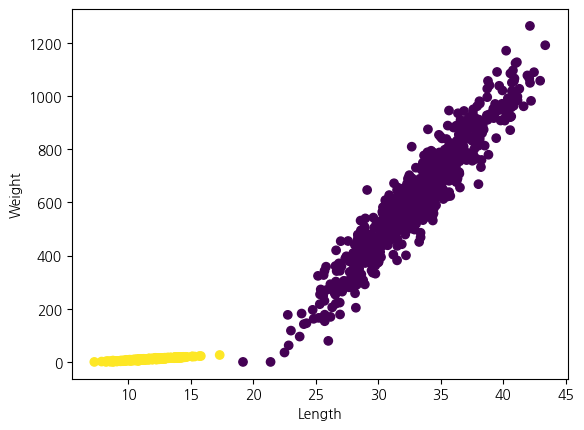

,Weight,Length
Weight,1.000000,0.961572
Length,0.961572,1.000000


In [7]:
# 시각화 : 산점도 => 색상을 품종에 따라 다르게 설정 c 매개변수
plt.scatter(fishDF.Length, fishDF.Weight, c = fishDF.Species.cat.codes) # cmap으로 색상 조절 가능
plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

# 상관계수
fishDF.corr(numeric_only=True)

[2] 피쳐/데이터와 타겟/라벨 분리 <hr>

In [8]:
# 학습용 피쳐/데이터와 타겟/라벨 분리
# -> 피쳐/데이터 : 2D
featureDF = fishDF[fishDF.columns[1:]]

# -> 타겟/라벨 : 1D
targetSR = fishDF[fishDF.columns[0]]

print(f'featureDF : {featureDF.shape} / {featureDF.ndim}D')
print(f'targetSR : {targetSR.shape} / {targetSR.ndim}D')

featureDF : (1000, 2) / 2D
targetSR : (1000,) / 1D


[3] 학습용, 테스트용 데이터셋 분리 <hr>
- 일반 -> 학습용 : 테스트용 = 8 : 2
- 수집된 데이터에 따라서 학습용 데이터셋 비율 설정
- scikit-learn 기본값 -> 7.5 : 2.5

In [9]:
# train_test_split(2D피쳐, 1D타겟, ...) => 반환 : 4개 원소 튜플
# ------------------------------------------------------------------------------------------------------
# 매개변수
# -> test_size = 0.25
# -> train_size = 0.75
# => 둘 중 하나만 입력하면 자동으로 계산해서 남은 하나 값 부여
# -> random_state = None : 전달한 데이터셋 섞기 -> 랜덤 추출
# -> stratify = None : 분류 학습 시 꼭 필수 설정, 데이터의 라벨/타켓을 동일 비율로 설정(한쪽으로 데이터 쏠림 방지)
# ------------------------------------------------------------------------------------------------------
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = targetSR)  


# 학습용, 테스트용 데이터 개수
print(f'[학습용] : {x_train.shape} {x_train.ndim}D / {y_train.shape} {y_train.ndim}D')
print(f'[테스트용] : {x_test.shape} {x_test.ndim}D / {y_test.shape} {y_test.ndim}D')  

# 2개 라벨/클래스 Bream, Smelt
# x = 길이 무게, y = 품종
targetL = (targetSR.value_counts() / targetSR.shape[0]).to_list()
trainL = (y_train.value_counts() / y_train.shape[0]).to_list()
testL = (y_test.value_counts() / y_test.shape[0]).to_list()

print(f'[Target] Bream : Smelt = {targetL[0]:.3f} : {targetL[1]:.3f}')
print(f'[Train] Bream : Smelt = {trainL[0]:.3f} : {trainL[1]:.3f}')
print(f'[Target] Bream : Smelt = {testL[0]:.3f} : {testL[1]:.3f}')


[학습용] : (800, 2) 2D / (800,) 1D
[테스트용] : (200, 2) 2D / (200,) 1D
[Target] Bream : Smelt = 0.700 : 0.300
[Train] Bream : Smelt = 0.700 : 0.300
[Target] Bream : Smelt = 0.700 : 0.300


[4] 학습 진행 => 학습용 데이터셋 <HR>
- 학습 알고리즘의 기본 설정값 그대로 학습 진행 => 성능 점수 : 베이스 점수 / 최저 점수 / 기준 점수
- 성능 향상을 위한 하이퍼 파라미터 튜닝 진행 => 학습 알고리즘별 하이퍼파라미터 체크

In [10]:
# x_train : 입력 특징값 / y_train : 라벨(정답)

# 훈련용/테스트용 성능 저장 : 1 ≤ ~ ≤ √데이터수
MAX_K = 31

scoreDict = {'Train': [], 'Test' : []}

# 최근접 이웃수 n_neighbors 범위 : 

# 최적 성능인 k 즉, n_neighbors 찾기
for k in range(1, MAX_K):
    # 모델 인스턴스 생성
    KModel = KNeighborsClassifier(n_neighbors=k)
    
    # 모델 학습 -> 학습용 데이터셋
    KModel.fit(x_train, y_train)

    # 모델 성능 평가 -> 테스트용 데이터셋
    train_score = KModel.score(x_train, y_train)
    test_score = KModel.score(x_test, y_test)
    print(f'[{k}] train_score : {train_score:.6f} / test_score : {test_score:.6f}')

    # 학습과 테스트 성능 비교를 위한 저장
    scoreDict['Train'].append(train_score)
    scoreDict['Test'].append(test_score)



[1] train_score : 1.000000 / test_score : 1.000000
[2] train_score : 1.000000 / test_score : 1.000000
[3] train_score : 0.998750 / test_score : 1.000000
[4] train_score : 0.998750 / test_score : 1.000000
[5] train_score : 0.996250 / test_score : 1.000000
[6] train_score : 0.996250 / test_score : 1.000000
[7] train_score : 0.996250 / test_score : 1.000000
[8] train_score : 0.996250 / test_score : 1.000000
[9] train_score : 0.993750 / test_score : 1.000000
[10] train_score : 0.993750 / test_score : 1.000000
[11] train_score : 0.993750 / test_score : 1.000000
[12] train_score : 0.993750 / test_score : 1.000000
[13] train_score : 0.993750 / test_score : 1.000000
[14] train_score : 0.993750 / test_score : 1.000000
[15] train_score : 0.993750 / test_score : 1.000000
[16] train_score : 0.993750 / test_score : 1.000000
[17] train_score : 0.993750 / test_score : 1.000000
[18] train_score : 0.993750 / test_score : 1.000000
[19] train_score : 0.993750 / test_score : 1.000000
[20] train_score : 0.

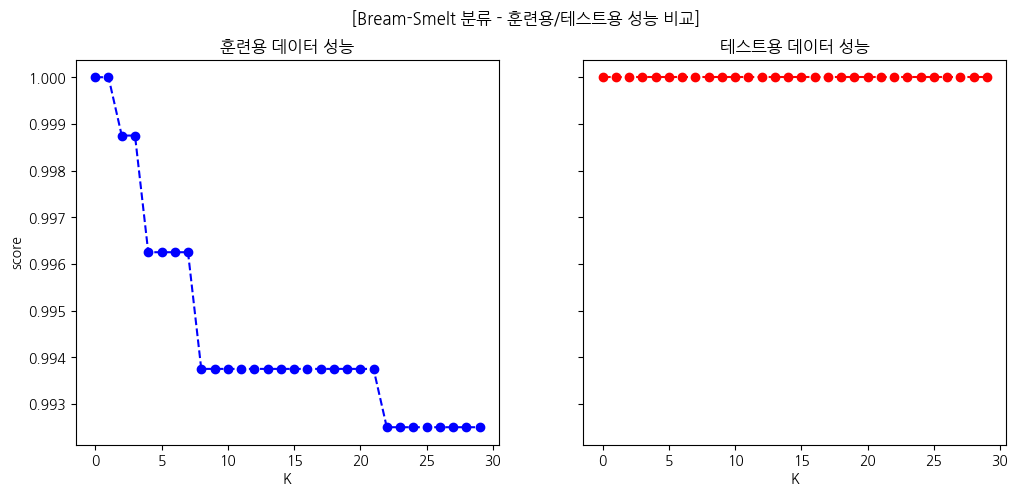

In [11]:
# k개수에 따른 학습 및 테스트 성능 시각화
fig, axes = plt.subplots(1,2, sharey = True, figsize=(12,5))

axes[0].plot(scoreDict['Train'], 'bo--')
axes[0].set_xlabel('K')
axes[0].set_ylabel('score')
axes[0].set_title("훈련용 데이터 성능")

axes[1].plot(scoreDict['Test'], 'ro--')
axes[1].set_xlabel('K')
axes[1].set_title("테스트용 데이터 성능")

plt.suptitle('[Bream-Smelt 분류 - 훈련용/테스트용 성능 비교]')
plt.show()

In [12]:
# ====================================================
# 최적의 K = 3 : 홀수, 학습한 모델 인스턴스 생성
# ====================================================
KModel = KNeighborsClassifier(n_neighbors=3)
KModel.fit(x_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


[5] 성능 평가 : 테스트용 데이터셋 <HR>
- 학습이 잘 되었는지 비교 평가
- 학습용 데이터셋 성능과 테스트용 데이터셋 성능 비교
- 평가
    * Good : 학습용 점수와 테스트용 점수 비슷 또는 테스트용 점수가 높음
    * Bad : 학습용 점수와 테스트용 점수가 낮은 경우 / 테스트용 점수만 낮은 경우

In [13]:
# 학습용/테스트용 점수 계산
train_score = KModel.score(x_train, y_train)
test_score = KModel.score(x_test, y_test)

print(f'[Train] {train_score}, [Test] {test_score}')

[Train] 0.99875, [Test] 1.0


[6] 예측 : 학습용/테스트용 아닌 일반 데이터들 <hr>
- 입력 데이터에 대한 예측 결과 반환
- 예시) 무게, 길이 입력 -> Bream, Smelt 반환

In [14]:
# 예측 진행
# W, L = 3.7, 9.8
in_data = [6.9, 9.8]
new_data = pd.DataFrame([in_data], columns = fishDF.columns[1:])

KModel.predict(new_data).item()     # ndarray에서 원소 1개 있는 경우 item() 원소 추출

'Smelt'

In [17]:
# 예측 검사 -> k개 이웃데이터 확인
_, indices = KModel.kneighbors(new_data)

indices[0].tolist()

[321, 192, 42]

[321, 192, 42]
[321] 6.559837633978775 10.195417062357198
[192] 6.75115952243378 10.49975917342142
[42] 6.195021885792334 9.998024987647408


C:\Users\qjadl\AppData\Local\Temp\ipykernel_22808\2426782810.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_train.Length, x_train.Weight, cmap='Palret2')


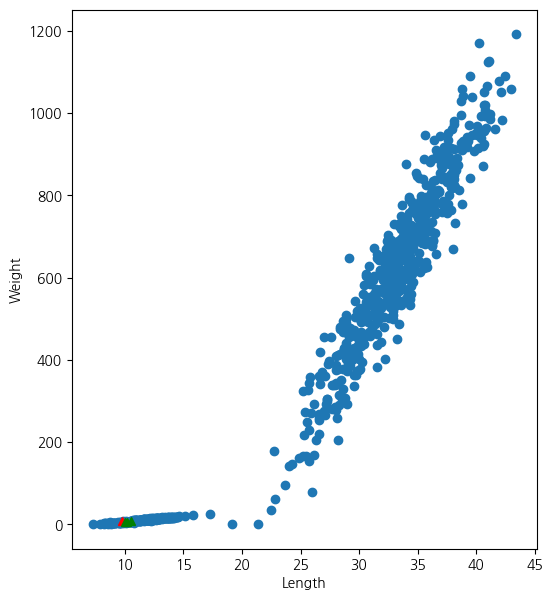

In [18]:
## 시각화
plt.figure(figsize=(6, 7))

plt.scatter(x_train.Length, x_train.Weight, cmap='Palret2')

#-> 새로운 데이터
plt.plot(new_data.Length, new_data.Weight, '^r')
#-> 이웃 데이터
nIdx = indices[0].tolist()
print(nIdx)
for idx in nIdx:
    print(f'[{idx:0>2}]',x_train.iloc[idx].Weight, x_train.iloc[idx].Length)
    plt.plot(x_train.iloc[idx].Length,x_train.iloc[idx].Weight, '^g')

plt.xlabel('Length')
plt.ylabel('Weight')
plt.show()

In [19]:
## Length, Weight의 값의 범위
x_train.describe().loc[['min','max']]

,Weight,Length
min,0.001000,7.279967
max,1191.671617,43.363260
